The purpose of this notebook is to demonstrate the methods in `methods/mp` and `methods/thomson` for computing nuclear wavefunctions and Franck-Condon factors for diatomic molecules.

In [1]:
import nepc.methods.mp as mp
import nepc.methods.thomson as thomson
from nepc.util.util import get_size
from nepc.util.constants import N2_DIATOMIC_CONSTANTS
from nepc.util.constants import MU_NITROGEN_KG
from nepc.util import scraper
from nepc.util import config
import pdfplumber
import numpy as np
import matplotlib.pyplot as plt

## Reference Franck-Condon Factors

As validation of our computational method, we will compare with available Franck-Condon factors from the literature.

In [2]:
nepcHome = config.nepc_home()
pdfHome = nepcHome + "/ref/angus/"
tmpdir = nepcHome + "/tmp/"

In [3]:
pdfGilmore = scraper.get_pdf(pdfHome + "30_gilmore_j_phys_chem_ref_data_21_1005_1992.pdf")

In [4]:
scraper.rmdir(tmpdir)
scraper.mkdir(tmpdir)

In [5]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [6]:
def fcf_extracted_gilmore(pdf, page_number, x_0, column_width, y_0, y_1, vpp_max, locate_tables, debug):
    crop_dim = []
    for i in range(vpp_max + 1):
        crop_dim.append([x_0+i*column_width, y_0, x_0+(i+1)*column_width, y_1])
    fcf_data = []
    for i in range(len(crop_dim)):
        if debug is True: 
            print("vpp: ", str(i))
        dataY = scraper.get_column_strings(pdf=pdfGilmore,
                                           page_number=page_number,
                                           crop_dim_array=crop_dim[i],
                                           locate_tables=locate_tables)
        if locate_tables is False:
            dataY=[s.replace('(', 'E') for s in dataY]
            dataY=[s.replace(')', '') for s in dataY]
            dataY=[s.replace('{', 'E') for s in dataY]
            dataY=[s.replace('}', '') for s in dataY]
            dataY=[s.replace('t', '') for s in dataY]
            dataY=[s.replace(',', '.') for s in dataY]
            dataY=[s.replace("'", '') for s in dataY]
            dataY=[s.replace(' ', '') for s in dataY]
            dataY=[s.replace('*', '') for s in dataY]
            dataY=[s.replace(':', '.') for s in dataY]
            dataY=[s.replace('~', '4') for s in dataY]
            dataY=[s.replace('E-4.', 'E-4') for s in dataY]
            dataY=[s.replace('.5.50E-2', '5.50E-2') for s in dataY]
            dataY=[s.replace('<1E', '4E') for s in dataY]
            dataY=[s.replace('<lE', '4E') for s in dataY]
            dataY=[s.replace('!E', '7E') for s in dataY]
            dataY=[s.replace('E1E', '0E') for s in dataY]
            dataY=[s.replace('8EE', '85E') for s in dataY]
            dataY=[s.replace('OE-I', '0E-1') for s in dataY]
            dataY=[s.replace('SE', '8E') for s in dataY]
            dataY=[s.replace(']E', '1E') for s in dataY]
            dataY=[s.replace('].42E-2', '1.42E-2') for s in dataY]
            dataY=[s.replace('UJ3E-I', '1.03E-1') for s in dataY]            
            dataY=scraper.text_array_to_float_array(dataY)
            fcf_data.append(flatten(dataY))
    if locate_tables is False:
        return fcf_data


In [7]:
"""data_fcf_n2_table_XX stores the FCF's from Gilmore, Table XX"""
data_fcf_n2_table_20 = fcf_extracted_gilmore(pdf=pdfGilmore,
                                                  page_number=86,
                                                  x_0=163,
                                                  column_width=47,
                                                  y_0=170,
                                                  y_1=490,
                                                  vpp_max=10,
                                                  locate_tables=False,
                                                  debug=False)

In [ ]:
#TODO: scrape remaining Franck-Condon factors for N2 and O2 for comparison

In [8]:
"""data_fcf_n2_table_XX stores the FCF's from Gilmore, Table XX"""
data_fcf_n2_table_28 = fcf_extracted_gilmore(pdf=pdfGilmore,
                                                  page_number=92,
                                                  x_0=163,
                                                  column_width=47,
                                                  y_0=170,
                                                  y_1=490,
                                                  vpp_max=10,
                                                  locate_tables=False,
                                                  debug=False)

In [9]:
data_fcf_n2_table_29 = fcf_extracted_gilmore(pdf=pdfGilmore,
                                                 page_number=93,
                                                 x_0=170,
                                                 column_width=47,
                                                  y_0=140,
                                                  y_1=450,
                                                 vpp_max=10,
                                                 locate_tables=False,
                                                 debug=False)

In [10]:
data_fcf_n2_table_30 = fcf_extracted_gilmore(pdf=pdfGilmore,
                                                 page_number=94,
                                                 x_0=175,
                                                 column_width=47,
                                                  y_0=170,
                                                  y_1=350,
                                                 vpp_max=10,
                                                 locate_tables=False,
                                                 debug=False)

In [11]:
data_fcf_n2_table_31 = fcf_extracted_gilmore(pdf=pdfGilmore,
                                                 page_number=95,
                                                 x_0=177,
                                                 column_width=47,
                                                  y_0=160,
                                                  y_1=330,
                                                 vpp_max=10,
                                                 locate_tables=False,
                                                 debug=False)

## Compute Overlap Integrals

As a validation, we can use the FCF code to compute overlap integrals for each state and check to make sure the diagonal elements are one and off-diagonal elements are zero.

In [12]:
#TODO: add remaining constants from NIST website to `nepc/util/constants.py`
#TODO: compute overlap integrals for all states and perform numerical checks below
N2_DIATOMIC_CONSTANTS.keys()

dict_keys(['N2(X1Sigmag+)', 'N2(A3Sigmau+)', 'N2(B3Pig)', 'N2+(X2Sigmag+)'])

In [13]:
p_list=['N2(X1Sigmag+)']
pp_list=['N2(X1Sigmag+)']
vp_list = np.arange(11)
vpp_list = np.arange(11)
jp_list = np.arange(1)
jpp_list = np.arange(1)
psi_p_keep = [p_list,[0,5,10],[0]]
psi_pp_keep = [pp_list,[0,5,10],[0]]
dbug = False

In [14]:
psi_p, psi_pp, fcf = thomson.fcf(p_list, pp_list,
                                 vp_list, vpp_list,
                                 jp_list, jpp_list,
                                 diatomic_constants=N2_DIATOMIC_CONSTANTS,
                                 reduced_mass=MU_NITROGEN_KG,
                                 k=17,
                                 delta_r=.5,
                                 psi_p_keep=psi_p_keep,
                                 psi_pp_keep=psi_pp_keep,
                                 dbug=False)

In [15]:
get_size(fcf)

6560

In [16]:
get_size(psi_p)

4196070

In [17]:
get_size(psi_pp)

4196070

In [18]:
psi_p

[{'state': 'N2(X1Sigmag+)',
  'v': 0,
  'j': 0,
  'r_array': array([0.59768   , 0.59769002, 0.59770004, ..., 1.59765996, 1.59766998,
         1.59768   ]),
  'psi_r': array([3.74429043e-42, 3.76235503e-42, 3.78050593e-42, ...,
         2.50009997e-18, 2.49658854e-18, 2.49308198e-18])},
 {'state': 'N2(X1Sigmag+)',
  'v': 5,
  'j': 0,
  'r_array': array([0.59768   , 0.59769002, 0.59770004, ..., 1.59765996, 1.59766998,
         1.59768   ]),
  'psi_r': array([-2.04202802e-38, -2.05177879e-38, -2.06157567e-38, ...,
          3.80776857e-12,  3.80310201e-12,  3.79844105e-12])},
 {'state': 'N2(X1Sigmag+)',
  'v': 10,
  'j': 0,
  'r_array': array([0.59768   , 0.59769002, 0.59770004, ..., 1.59765996, 1.59766998,
         1.59768   ]),
  'psi_r': array([7.16210588e-36, 7.19596960e-36, 7.22999182e-36, ...,
         1.41141041e-07, 1.40995599e-07, 1.40850303e-07])}]

In [19]:
psi_pp

[{'state': 'N2(X1Sigmag+)',
  'v': 0,
  'j': 0,
  'r_array': array([0.59768   , 0.59769002, 0.59770004, ..., 1.59765996, 1.59766998,
         1.59768   ]),
  'psi_r': array([3.74429043e-42, 3.76235503e-42, 3.78050593e-42, ...,
         2.50009997e-18, 2.49658854e-18, 2.49308198e-18])},
 {'state': 'N2(X1Sigmag+)',
  'v': 5,
  'j': 0,
  'r_array': array([0.59768   , 0.59769002, 0.59770004, ..., 1.59765996, 1.59766998,
         1.59768   ]),
  'psi_r': array([-2.04202802e-38, -2.05177879e-38, -2.06157567e-38, ...,
          3.80776857e-12,  3.80310201e-12,  3.79844105e-12])},
 {'state': 'N2(X1Sigmag+)',
  'v': 10,
  'j': 0,
  'r_array': array([0.59768   , 0.59769002, 0.59770004, ..., 1.59765996, 1.59766998,
         1.59768   ]),
  'psi_r': array([7.16210588e-36, 7.19596960e-36, 7.22999182e-36, ...,
         1.41141041e-07, 1.40995599e-07, 1.40850303e-07])}]

In [20]:
print(np.diagonal(fcf[0][0][0][0]))

[1.         1.         1.         1.         1.         1.
 1.         0.99999997 0.99999995 1.00000015 0.99999843]


In [21]:
thomson.off_diagonal_elements(np.array(fcf[0][0][0][0]))

array([1.31257872e-26, 1.71856378e-22, 5.23673618e-25, 6.44645746e-21,
       8.52580014e-23, 1.45670903e-24, 7.75789831e-19, 3.63224219e-20,
       1.04587287e-21, 2.01426635e-24, 8.49225381e-16, 5.26122213e-17,
       8.40829245e-19, 1.10477945e-21, 2.37189649e-21, 6.72660658e-14,
       2.35102250e-15, 2.19533141e-17, 1.20616341e-21, 5.22408723e-19,
       6.76974818e-20, 1.20648491e-12, 4.93696319e-14, 8.68281564e-16,
       3.53154596e-19, 2.88462540e-17, 6.94231148e-18, 3.72497924e-17,
       2.87529545e-12, 3.78260651e-12, 5.00920388e-13, 2.16826445e-14,
       4.03705118e-16, 7.76541857e-16, 1.92083959e-15, 3.13698609e-15,
       9.91139245e-09, 1.73782709e-09, 9.73295821e-11, 2.62703217e-12,
       1.77709420e-14, 1.30815746e-16, 8.41527178e-14, 6.30593594e-16,
       1.37024866e-14, 7.14674469e-07, 9.88227994e-08, 5.15955257e-09,
       1.20599937e-10, 2.13685885e-13, 2.31423367e-12, 1.12199117e-12,
       2.90774408e-12, 6.52264810e-16, 2.45393176e-12, 1.31257872e-26,
      

In [22]:
thomson.rmse_off_diagonal_elements(np.array(fcf[0][0][0][0]))

9.729556119587217e-08

### Incremental RMSE

We can compute the RMSE as a function of v' to see how the cumulative error grows as we increase the number of vibrational levels.

In [23]:
thomson.incremental_rmse_off_diagonal_elements(np.array(fcf[0][0][0][0]))

i: 2; rmse: 1.3125787211329585e-26
i: 3; rmse: 9.922178722957653e-23
i: 4; rmse: 2.632920424154992e-21
i: 5; rmse: 2.456037188161354e-19
i: 6; rmse: 2.1968964528320254e-16
i: 7; rmse: 1.4688796109559054e-14
i: 8; rmse: 2.2854937959278986e-13
i: 9; rmse: 8.214049031734554e-13
i: 10; rmse: 1.5001129409962704e-09
i: 11; rmse: 9.729556119587217e-08


In [24]:
thomson.incremental_rmse_diagonal_elements(np.array(fcf[0][0][0][0]))

i: 1; rmse: 4.938272013532696e-13
i: 2; rmse: 3.7066953457539996e-13
i: 3; rmse: 3.2528688365428066e-13
i: 4; rmse: 7.275485889631496e-13
i: 5; rmse: 5.251117677675936e-12
i: 6; rmse: 5.7800421734480834e-11
i: 7; rmse: 1.2400695278075107e-09
i: 8; rmse: 1.0145905172926967e-08
i: 9; rmse: 1.86931074197029e-08
i: 10; rmse: 5.0416387723099454e-08
i: 11; rmse: 4.7506020534286805e-07


In [25]:
np.diagonal(np.array(fcf[0][0][0][0]))-1

array([ 4.93827201e-13, -1.75859327e-13, -2.06501483e-13,  1.34159350e-12,
       -1.16513466e-11,  1.41093803e-10,  3.27785932e-09, -2.85087833e-08,
       -4.81806522e-08,  1.49242189e-07, -1.56750951e-06])

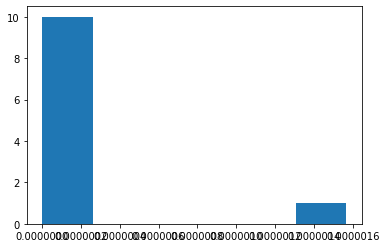

In [26]:
fcf_diagonal_error = np.sqrt((np.diagonal(np.array(fcf[0][0][0][0]))-1)**2)
# histogram on linear scale
#plt.subplot(311)
hist, bins, _ = plt.hist(fcf_diagonal_error, bins=6)

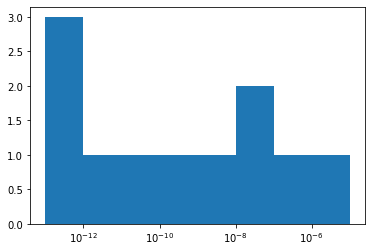

In [27]:
# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
bin_first = round(np.log10(bins[0]))
bin_last = round(np.log10(bins[-1])+1)
logbins = np.logspace(bin_first, bin_last, abs(bin_first) - abs(bin_last)+1)
#plt.subplot(312)
plt.hist(fcf_diagonal_error, bins=logbins)
plt.xscale('log')
plt.show()

### Check of delta_r

We can visually inspect plots of psi_p, psi_pp, and psi_p x psi_pp for the highest vibrational modes to ensure that we have captured the entire wavefunction (but haven't made the integration limits too large).

In [28]:
psi_0 = psi_p[1]['psi_r']
r_array_0 = psi_p[1]['r_array']
psi_1 = psi_p[2]['psi_r']
r_array_1 = psi_p[2]['r_array']
psi_0_1 = psi_0 * psi_1

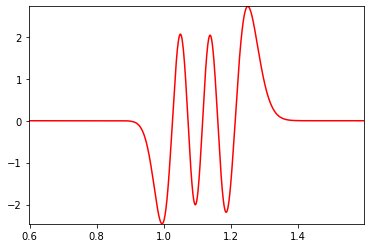

In [29]:
plt.plot(r_array_0,psi_0, 'r')
plt.axis([min(r_array_0), max(r_array_0), min(psi_0), max(psi_0)])
plt.show()

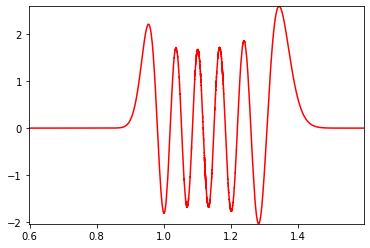

In [30]:
plt.plot(r_array_1, psi_1, 'r')
plt.axis([min(r_array_1), max(r_array_1), min(psi_1), max(psi_1)])
plt.show()

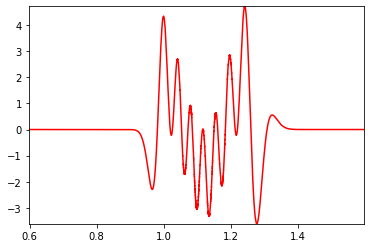

In [31]:
plt.plot(r_array_0, psi_0_1, 'r')
plt.axis([min(r_array_0), max(r_array_0), min(psi_0_1), max(psi_0_1)])
plt.show()

## FCFs

Now, we compute FCFs for the case where p' and p'' differ, compare with Gilmore's results, and also look at closure relationships.

In [32]:
N2_DIATOMIC_CONSTANTS.keys()

dict_keys(['N2(X1Sigmag+)', 'N2(A3Sigmau+)', 'N2(B3Pig)', 'N2+(X2Sigmag+)'])

In [33]:
p_list=['N2(X1Sigmag+)']
pp_list=['N2(B3Pig)']
vp_list = np.arange(11)
vpp_list = np.arange(11)
jp_list = np.arange(1)
jpp_list = np.arange(1)
psi_p_keep = [p_list,[0,5,10],[0]]
psi_pp_keep = [pp_list,[0,5,10],[0]]
dbug = False

In [34]:
psi_p, psi_pp, fcf = thomson.fcf(p_list, pp_list,
                                 vp_list, vpp_list,
                                 jp_list, jpp_list,
                                 diatomic_constants=N2_DIATOMIC_CONSTANTS,
                                 reduced_mass=MU_NITROGEN_KG,
                                 k=17,
                                 delta_r=.5,
                                 psi_p_keep=psi_p_keep,
                                 psi_pp_keep=psi_pp_keep,
                                 dbug=False)

In [35]:
for i in range(len(fcf[0][0][0][0])):
    print('\nv\'/v\'\': {}'.format(i))
    for j in range(len(fcf[0][0][0][0][0])):
        print('{}\t{:.2E}\t{:.2E}'.format(j, data_fcf_n2_table_20[i][j], fcf[0][0][0][0][i][j]))



v'/v'': 0
0	6.11E-02	6.05E-02
1	1.47E-01	1.46E-01
2	1.95E-01	1.95E-01
3	1.90E-01	1.90E-01
4	1.51E-01	1.52E-01
5	1.05E-01	1.06E-01
6	6.65E-02	6.66E-02
7	3.90E-02	3.90E-02
8	2.16E-02	2.16E-02
9	1.15E-02	1.15E-02
10	5.92E-03	5.90E-03

v'/v'': 1
0	1.91E-01	1.89E-01
1	1.93E-01	1.93E-01
2	6.54E-02	6.62E-02
3	7.17E-04	8.04E-04
4	2.58E-02	2.55E-02
5	7.60E-02	7.59E-02
6	1.04E-01	1.04E-01
7	1.03E-01	1.03E-01
8	8.39E-02	8.42E-02
9	6.04E-02	6.06E-02
10	3.98E-02	3.99E-02

v'/v'': 2
0	2.74E-01	2.73E-01
1	4.50E-02	4.62E-02
2	2.39E-02	2.30E-02
3	1.05E-01	1.04E-01
4	8.38E-02	8.44E-02
5	2.07E-02	2.11E-02
6	5.33E-04	4.96E-04
7	2.49E-02	2.49E-02
8	5.85E-02	5.88E-02
9	7.72E-02	7.78E-02
10	7.73E-02	7.79E-02

v'/v'': 3
0	2.41E-01	2.41E-01
1	1.59E-02	1.48E-02
2	1.30E-01	1.30E-01
3	3.60E-02	3.70E-02
4	7.32E-03	6.86E-03
5	6.56E-02	6.52E-02
6	7.50E-02	7.53E-02
7	3.34E-02	3.38E-02
8	2.39E-03	2.44E-03
9	6.14E-03	6.21E-03
10	3.00E-02	3.04E-02

v'/v'': 4
0	1.44E-01	1.45E-01
1	1.42E-01	1.39E-01
2	4.81E-02	4.97E-02
3

These calculated FCF's appear to be fairly close to Gilmore's results, especially for v', v'' < 5.

In [36]:
thomson.rmse_calc_ref(np.array(fcf[0][0][0][0]), data_fcf_n2_table_20)

0.0011526260122714964

In [46]:
p_list=['N2(X1Sigmag+)']
pp_list=['N2+(X2Sigmag+)']
vp_list = np.arange(11)
vpp_list = np.arange(11)
jp_list = np.arange(1)
jpp_list = np.arange(1)
psi_p_keep = [p_list,[0,5,10],[0]]
psi_pp_keep = [pp_list,[0,5,10],[0]]
dbug = False

In [47]:
psi_p, psi_pp, fcf = thomson.fcf(p_list, pp_list,
                                 vp_list, vpp_list,
                                 jp_list, jpp_list,
                                 diatomic_constants=N2_DIATOMIC_CONSTANTS,
                                 reduced_mass=MU_NITROGEN_KG,
                                 k=17,
                                 delta_r=.5,
                                 psi_p_keep=psi_p_keep,
                                 psi_pp_keep=psi_pp_keep,
                                 dbug=False)

In [48]:
thomson.print_fcf_calc_ref(fcf[0][0][0][0], data_fcf_n2_table_28)


v'/v'': 0
0	9.17E-01	9.17E-01
1	7.79E-02	7.83E-02
2	4.65E-03	4.67E-03
3	2.68E-04	2.67E-04
4	1.76E-05	1.70E-05
5	1.55E-06	1.28E-06
6	2.13E-07	1.16E-07
7	4.74E-08	1.25E-08
8	1.47E-08	1.39E-09
9	5.49E-09	7.75E-10
10	2.24E-09	1.70E-09

v'/v'': 1
0	8.02E-02	8.06E-02
1	7.60E-01	7.58E-01
2	1.45E-01	1.46E-01
3	1.38E-02	1.38E-02
4	1.12E-03	1.09E-03
5	9.62E-05	8.77E-05
6	1.06E-05	7.95E-06
7	1.71E-06	8.39E-07
8	4.21E-07	1.03E-07
9	1.42E-07	1.18E-08
10	5.67E-08	5.10E-09

v'/v'': 2
0	2.53E-03	2.59E-03
1	1.54E-01	1.55E-01
2	6.12E-01	6.10E-01
3	2.01E-01	2.02E-01
4	2.72E-02	2.72E-02
5	2.89E-03	2.77E-03
6	3.14E-04	2.72E-04
7	4.18E-05	2.88E-05
8	7.79E-06	3.46E-06
9	2.11E-06	4.76E-07
10	7.58E-07	6.68E-08

v'/v'': 3
0	4.47E-05	4.70E-05
1	7.91E-03	8.10E-03
2	2.21E-01	2.22E-01
3	4.75E-01	4.75E-01
4	2.44E-01	2.45E-01
5	4.45E-02	4.40E-02
6	6.00E-03	5.60E-03
7	7.97E-04	6.52E-04
8	1.25E-04	7.94E-05
9	2.65E-05	1.07E-05
10	7.79E-06	1.61E-06

v'/v'': 4
0	4.17E-07	4.91E-07
1	2.04E-04	2.09E-04
2	1.65E-02	1.68E-02
3

In [49]:
thomson.rmse_calc_ref(np.array(fcf[0][0][0][0]), data_fcf_n2_table_28)

0.023184043388411773

A check of the closure relationship.

#TODO: explain this; what does it mean exactly?

In [50]:
thomson.fcf_closure(fcf[0][0][0][0])

v'	closure_vp
0	1.0000000021331412
1	1.0000000011538985
2	0.9999999849640492
3	0.9999996754398927
4	0.9999944400311878
5	0.9999234690525584
6	0.9991185109944564
7	0.9917309332251839
8	0.9430207456596036
9	0.7592436440663655
10	0.5237038541372935

v''	closure_vpp
0	1.0000008065548889
1	1.0000000053339373
2	0.9999999999788536
3	0.9999999999359711
4	1.0000000004676097
5	0.9999999905918385
6	0.9999947282076345
7	0.9995099091507826
8	0.983186329826082
9	0.8096005743622836
10	0.42444291644774834


In [41]:
psi_0 = psi_p[2]['psi_r']
r_array_0 = psi_p[2]['r_array']
psi_1 = psi_pp[2]['psi_r']
r_array_1 = psi_pp[2]['r_array']
psi_0_1 = psi_0 * psi_1

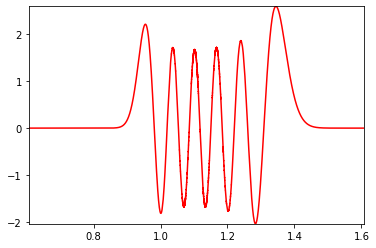

In [42]:
plt.plot(r_array_0,psi_0, 'r')
plt.axis([min(r_array_0), max(r_array_0), min(psi_0), max(psi_0)])
plt.show()

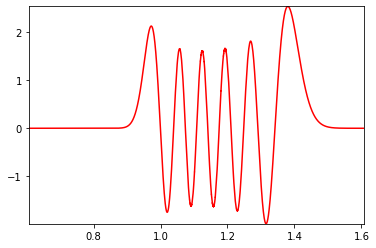

In [43]:
plt.plot(r_array_1, psi_1, 'r')
plt.axis([min(r_array_1), max(r_array_1), min(psi_1), max(psi_1)])
plt.show()

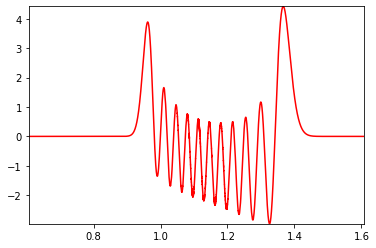

In [44]:
plt.plot(r_array_0, psi_0_1, 'r')
plt.axis([min(r_array_0), max(r_array_0), min(psi_0_1), max(psi_0_1)])
plt.show()

In [45]:
thomson.fcf_closure(fcf[0][0][0][0])

v'	closure_vp
0	1.0000000021331412
1	1.0000000011538985
2	0.9999999849640492
3	0.9999996754398927
4	0.9999944400311878
5	0.9999234690525584
6	0.9991185109944564
7	0.9917309332251839
8	0.9430207456596036
9	0.7592436440663655
10	0.5237038541372935

v''	closure_vpp
0	1.0000008065548889
1	1.0000000053339373
2	0.9999999999788536
3	0.9999999999359711
4	1.0000000004676097
5	0.9999999905918385
6	0.9999947282076345
7	0.9995099091507826
8	0.983186329826082
9	0.8096005743622836
10	0.42444291644774834
